In [ ]:
#!pip -q install plotly --upgrade
#!pip -q install yellowbrick

Dataset All: 5644 linhas | 107 colunas
Dataset Clean: 5644 linhas | 37 colunas
Colunas que foram transformadas: 20
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1675
           1       0.25      0.12      0.16       188

    accuracy                           0.87      1863
   macro avg       0.58      0.54      0.55      1863
weighted avg       0.84      0.87      0.85      1863

[[1605   70]
 [ 165   23]]
Acurácia do modelo: 0.87




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Matriz de Confusão Naive Bayes:
[[1674    1]
 [ 188    0]]
Matriz de Confusão Árvore de Decisão:
[[1661   14]
 [ 174   14]]
Relatório de Classificação Naive Bayes:
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1675
           1       0.00      0.00      0.00       188

    accuracy                           0.90      1863
   macro avg       0.45      0.50      0.47      1863
weighted avg       0.81      0.90      0.85      1863

Relatório de Classificação Árvore de Decisão:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      1675
           1       0.50      0.07      0.13       188

    accuracy                           0.90      1863
   macro avg       0.70      0.53      0.54      1863
weighted avg       0.86      0.90      0.86      1863



Acurácia KNN: 0.8797638217928073




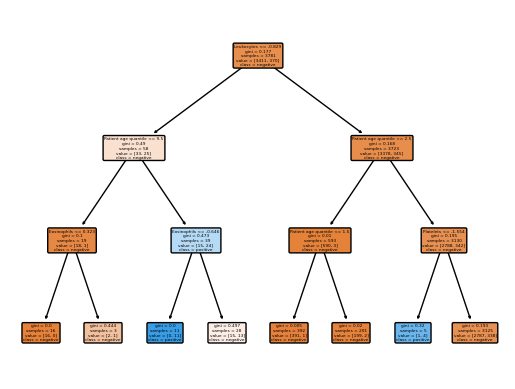

In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import graphviz 
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report


base_dados = pd.read_excel('./dataset.xlsx')


column_drops = ['Patient ID', 
                'Patient addmited to intensive care unit (1=yes, 0=no)',
                'Patient addmited to regular ward (1=yes, 0=no)',
                'Patient addmited to semi-intensive unit (1=yes, 0=no)',
                ]


data_clean = base_dados.drop(columns=column_drops)


# Imprimindo informações iniciais sobre o dataset
print("Dataset All: {} linhas | {} colunas".format(data_clean.shape[0], data_clean.shape[1]))

# Calculando a porcentagem máxima de valores nulos permitida
porcentagem_maxima_nulos = data_clean.isna().mean().mean()

# Eliminando as colunas com porcentagem de valores nulos maior ou igual à porcentagem máxima permitida: 95%
data_clean.dropna(thresh=len(data_clean)*(1-porcentagem_maxima_nulos), axis=1, inplace=True)

print("Dataset Clean: {} linhas | {} colunas".format(data_clean.shape[0], data_clean.shape[1]))


# identifica as colunas que são do tipo 'object'

label_encoder = LabelEncoder()

cols_object = data_clean.select_dtypes(include=['object']).columns

# aplica a transformação LabelEncoder nas colunas identificadas
data_clean[cols_object] = data_clean[cols_object].apply(lambda col: label_encoder.fit_transform(col.astype(str)))

# preenche os valores nulos com a média de cada coluna
data_clean = data_clean.fillna(data_clean.mean())

# calcula a correlação com a coluna "SARS-Cov-2 exam result"
coluna_result = "SARS-Cov-2 exam result"
correlacao_01 =  data_clean.corrwith(data_clean[coluna_result], numeric_only=True)


# exibe a quantidade de colunas transformadas
print(f'Colunas que foram transformadas: {len(cols_object)}')


# Selecionar as 10 colunas com maior correlação com o resultado do teste COVID-19
m_cols = correlacao_01.abs().nlargest(10).index[1:]

# Divisão dos dados em conjunto de treinamento e teste
X = data_clean[m_cols]
y = data_clean[coluna_result]
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(X, y, test_size=0.33, random_state=90)


# Testa ser deu Certo
"""
X_treinamento.shape, y_treinamento.shape
X_teste.shape, y_teste.shape
"""


# Naive Bayes


naive_bayes = GaussianNB()
naive_bayes.fit(X_treinamento, y_treinamento)

# Previsão nos dados de teste
y_pred = naive_bayes.predict(X_teste)

# Avaliação do modelo
print(classification_report(y_teste, y_pred))
print(confusion_matrix(y_teste, y_pred))

# Criando um pipeline para padronização e treinamento do modelo
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nb', naive_bayes)
])

# Treinando o modelo
pipeline.fit(X_treinamento, y_treinamento)

# Testando o modelo
y_pred = pipeline.predict(X_teste)

# Verificando a acurácia do modelo
acuracia = pipeline.score(X_teste, y_teste)
print(f"Acurácia do modelo: {acuracia:.2f}")

print()
print()

# Árvores de decisão


decision_tree = DecisionTreeClassifier()

decision_tree.fit(X_treinamento, y_treinamento)

# Avaliando o modelo com os dados de teste

y_pred_naive_bayes = naive_bayes.predict(X_teste)

y_pred_decision_tree = decision_tree.predict(X_teste)

# Matriz de Confusão

confusion_matrix_naive_bayes = confusion_matrix(y_teste, y_pred_naive_bayes)

confusion_matrix_decision_tree = confusion_matrix(y_teste, y_pred_decision_tree)

print("Matriz de Confusão Naive Bayes:")
print(confusion_matrix_naive_bayes)
print("Matriz de Confusão Árvore de Decisão:")
print(confusion_matrix_decision_tree)


# Métricas de Avaliação

print("Relatório de Classificação Naive Bayes:")
print(classification_report(y_teste, y_pred_naive_bayes))


print("Relatório de Classificação Árvore de Decisão:")
print(classification_report(y_teste, y_pred_decision_tree))


# Instanciando o classificador com a profundidade máxima desejada
clf_tree = DecisionTreeClassifier(max_depth=3)

# Treinando o modelo com os dados de treinamento
clf_tree.fit(X_treinamento, y_treinamento)

# Plotando a árvore de decisão
dot_data = plot_tree(clf_tree, filled=True, rounded=True, feature_names=m_cols, class_names=["negative", "positive"])
graph = graphviz.Source(dot_data)
graph

print()
print()

# KNN

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_treinamento, y_treinamento)

y_knn = knn.predict(X_teste)

print("Acurácia KNN:", knn.score(X_teste, y_teste))
print()
print()




